In [1]:
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools

import scipy.linalg as sc

import warnings as w
from IPython.display import Image

from utils import qualityMACAPE, qualityRMSE, InitExponentialSmoothing, AdaptiveExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
from sklearn.utils.extmath import softmax

In [3]:
softmax([[1.,3,3],[3.,1.,0] ])

array([[0.06337894, 0.46831053, 0.46831053],
       [0.84379473, 0.1141952 , 0.04201007]])

In [4]:
# k = 2
# x = [1,2,3,4]
# h = 1
# forecast_ba = np.array( [[-1, -2, -3, -4, -5], [-2, -4, -6, -8, -10]] )
# sc.hankel( x[:-(k-1)], [-1]+list(x[-(k-1):]) )[:-h, :], forecast_ba[:, k-1+h:-h]

In [5]:
def arbitrating_composition(ts, h, params):
    '''
    Parameters
    ts <K \times array> - batch of time series shape=(batch_size, K)
    h <integer scalar> - forecasting delay
    params <dict> - dictionary with 

        base_algs - array of <dict> with params
            base_alg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    base_algs = params['base_alg_params']
    
    forecast = np.empty( (len(ts), len(ts[0]) + h) )
    forecast[:] = np.nan
    
    X_train, Y_train = None, None
    rf = [ RandomForestRegressor() for _ in range(len(base_algs)) ]  # random forest
    is_fitted = False
    
    for i_x, x in enumerate(ts):
        ts[i_x][ np.isnan(x) ] = x[np.logical_not(np.isnan(x))].mean()

        forecast_ba = np.empty(( len(base_algs), len(x) + h ))
        forecast_ba[:] = np.nan
    
        #     forecast TS by each base algs
        #     be careful with eval() function    
        for n, base_alg in enumerate(base_algs):
            forecast_ba[n] = eval(base_alg['base_alg'])(x, h, base_alg['base_algs_params'])
        
        step = 10  # TODO: make it parameter
        k = 10  # size of sample for meta-learner TODO: make it parameter
        
        xx = sc.hankel( x[:-(k-1)], [-1]+list(x[-(k-1):]) )[:-h, :]
        yy = np.abs(forecast_ba[:, k-1+h:-h] - np.vstack([ x[k-1+h:], x[k-1+h:] ]))
        #print(xx.shape, yy.shape)
        
        for t in range( yy.shape[1] + k-1+h ):
            #print(t, (t >= k-1+h) , (not np.isnan(yy[:, t-(k-1+h)]).any()) , is_fitted)
            if (t >= k-1+h) and (not np.isnan(yy[:, t-(k-1+h)]).any()) and is_fitted:
                x_t = xx[t - (k-1+h)]
                #x_t[np.isnan(x_t)] = np.finfo(np.float32).max
                
                ans = [ rf[i].predict([x_t])[0] for i in range(len(rf)) ]
                forecast[i_x, t] = np.dot(softmax([ans])[0], forecast_ba[:, t])
                #print(forecast[i_x, t])
            if (t % step == 0) and (t != 0):
                for i in range(len(rf)):
                    if X_train is None:
                        batch_x, batch_y = xx[:t-(k-1+h), :], yy[i, :t-(k-1+h)]
                    else:
                        batch_x, batch_y = np.vstack( (X_train, xx[:t-(k-1+h)] )), np.append(Y_train[i, :], yy[i, :t-(k-1+h)])
                    #not_nan_ind = np.logical_not(np.isnan(batch_y))
                    #batch_x, batch_y = batch_x[not_nan_ind], batch_y[not_nan_ind]
                    if batch_y.shape[0] != 0:
                        #batch_x[np.isnan(batch_x)] = np.finfo(np.float32).max
                        rf[i] = RandomForestRegressor()
                        #print(batch_x.shape, batch_y.shape)
                        rf[i].fit( batch_x, batch_y )
                        is_fitted = True
        if X_train is None:
            X_train, Y_train = xx, yy
        else:
            X_train, Y_train = np.vstack( (X_train, xx) ), np.hstack( (Y_train, yy) )
        print(i_x, X_train.shape)
    return forecast

# Define base algorithms

In [6]:
base_algs = [{'base_alg':'InitExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'base_alg':'AdaptiveExponentialSmoothing', 'base_algs_params':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
#                  {'base_alg':'AdaptiveSimpleExponentialSmoothing', 'base_algs_params':{'alpha':0.1, 'gamma':0.01}},
#                 {'base_alg':'TheilWageSmoothing', 'base_algs_params':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [7]:
for ba in range(len(base_algs)):
    print(base_algs[ba]['base_alg']+"(x,h,"+"base_algs["+str(ba)+"]['base_alg_params'])")

InitExponentialSmoothing(x,h,base_algs[0]['base_alg_params'])
AdaptiveExponentialSmoothing(x,h,base_algs[1]['base_alg_params'])


In [8]:
# Read data (time series)
#ts = pd.read_csv('https://raw.githubusercontent.com/ml-mipt/ml-mipt-part2/master/2017/seminars/1_ts_esm/data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names = ['Timestamp']
ts = ts.sort_index() # sort index

In [9]:
# Define forecast perameters
h = 1 # horizon forecast

# structure of forecasts
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h))), columns = ts.columns)
FRC_TS = dict()

In [10]:
[ ts[cntr].shape for cntr in ts.columns]

[(1512,),
 (1512,),
 (1512,),
 (1512,),
 (1512,),
 (1512,),
 (1512,),
 (1512,),
 (1512,),
 (1512,),
 (1512,)]

In [11]:
gamma = 0.01
eps = 1.0
params = {'gamma': gamma, 'eps': eps, 'base_alg_params': base_algs}
forecast = arbitrating_composition([ ts[cntr] for cntr in ts.columns], h, params)

0 (1502, 10)
1 (3004, 10)
2 (4506, 10)
3 (6008, 10)
4 (7510, 10)
5 (9012, 10)
6 (10514, 10)
7 (12016, 10)
8 (13518, 10)
9 (15020, 10)
10 (16522, 10)


In [14]:
forecast[ np.logical_not(np.isnan(forecast)) ].shape

(16511,)

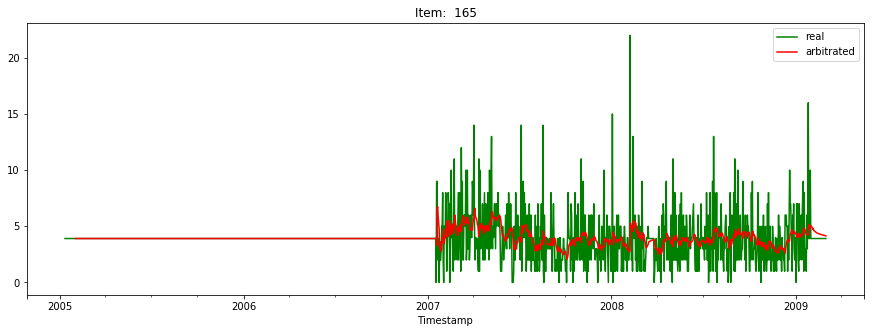

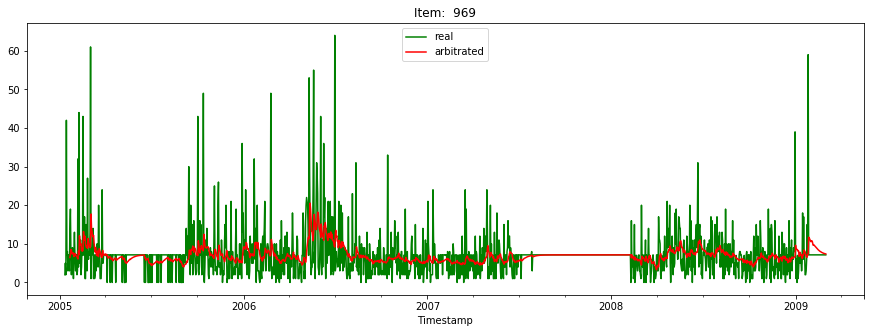

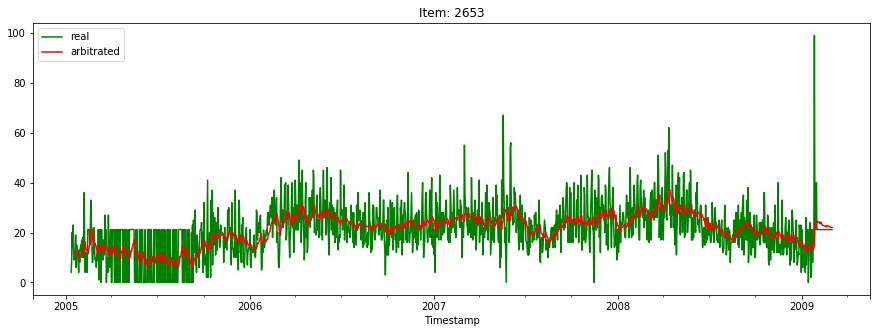

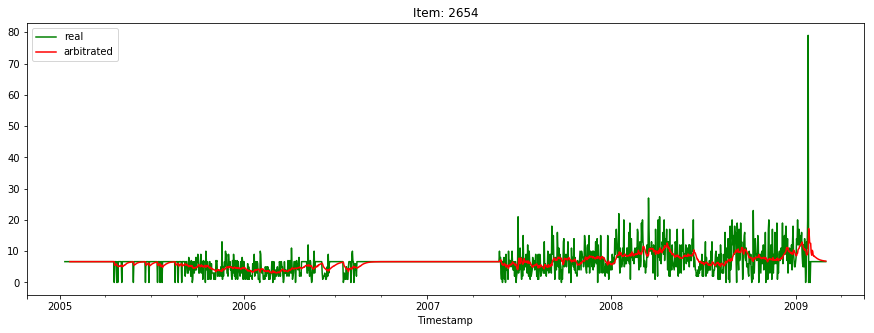

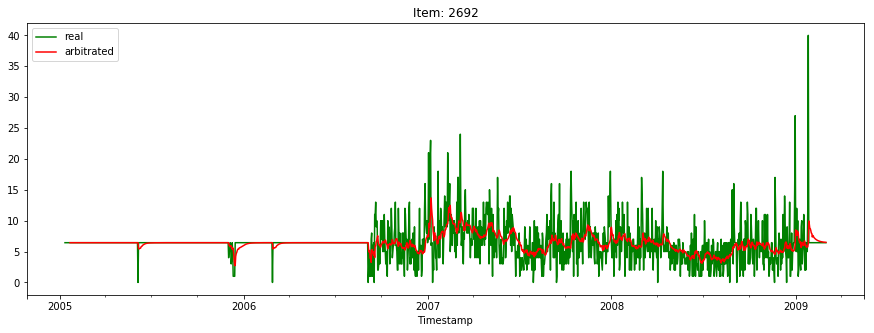

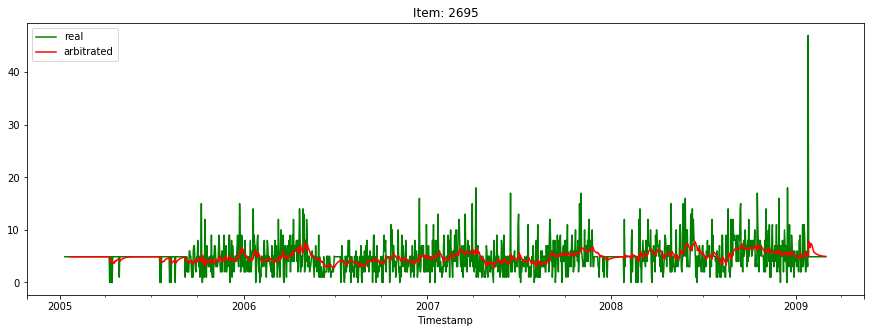

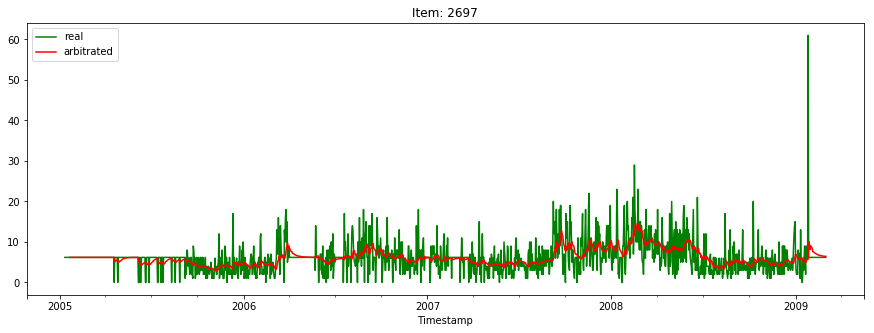

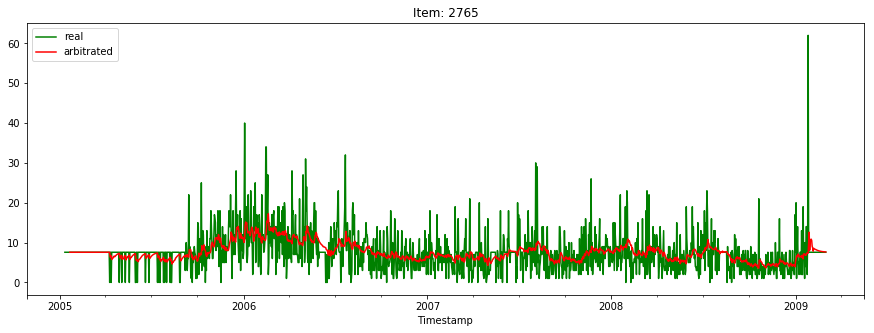

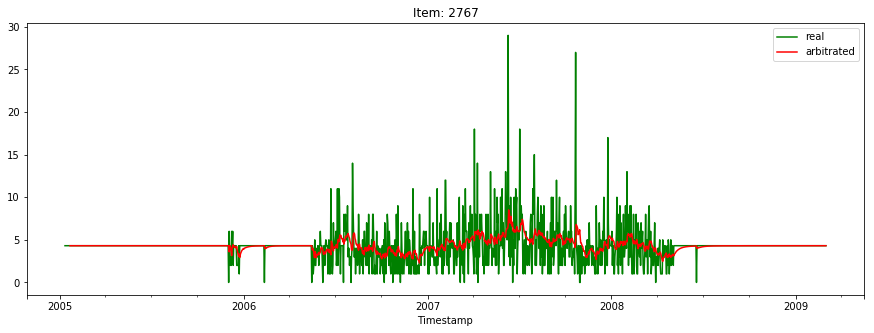

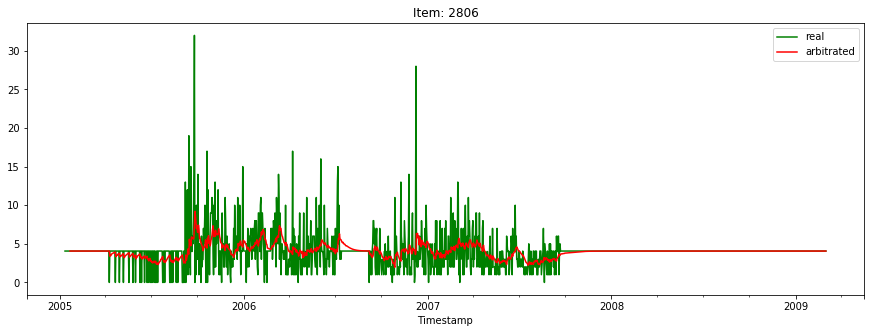

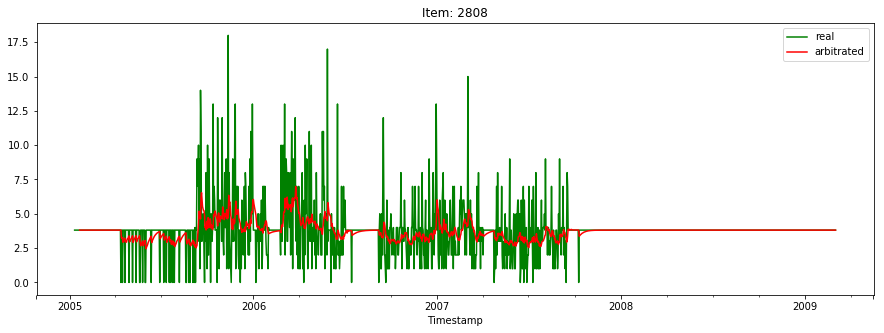

In [45]:
for i, col in enumerate(ts.columns):
    ts[col].plot(figsize=(15,5), color='green', label='real')
    pd.Series(data=forecast[i, :-1], index=ts[col].index).plot(color='red', label='arbitrated')
    
    plt.title(col)
    plt.legend()
    plt.show()